In [3]:
import numpy as np
import xarray as xr
from dependence_metrics import kendallstau, utdc_at_threshold, utdc_cfg

In [4]:
def pot(da,threshold,dim):
    return da.where(da>da.quantile(threshold,dim=dim))

First, open rain & surge. For now, using an example for MPI-ESM1-2-HR, this should be adapted to the workflow to derive the rain & surge later.

In [5]:
rain_surges = xr.open_mfdataset('/home/jovyan/CMIP6cf/notebooks/MPI-ESM1-2-HR_gn_day_tg_*')
#surges = xr.open_dataset('/home/jovyan/CMIP6cf/notebooks/MPI-ESM1-2-HR_gn_day_tg_surges.nc')
#rain_surges = xr.merge((rain,surges))

Now construct multiple time windows to apply the analysis to, for now using a window length of 30 years:

In [6]:
output_yrs = np.arange(1875,2100,15)

#remove leap days so that each computation window has the same length
rain_surges = rain_surges.sel(time=~((rain_surges.time.dt.month == 2) & (rain_surges.time.dt.day == 29))) 
days_in_year = int(np.mean(rain_surges.time.resample(time='1Y').count().values))

window_start_idx = days_in_year*(output_yrs-1850-14) #using window length of 30 here
first_window_idx = np.arange(0*days_in_year,30*days_in_year)

window_idx = xr.DataArray(
    data=first_window_idx[:,np.newaxis]+window_start_idx[np.newaxis,:],
    dims=["time_in_window_idx","window_center"],
    coords=dict(
        time_in_window_idx=first_window_idx,
        window_center=output_yrs
    ),
)

rain_surges_windows = rain_surges.isel(time=window_idx)

Configure and apply the bivariate sampling:

In [7]:
max_lag = 2
declustering_window = 3
threshold = .97

In [8]:
#compute peaks
pr_peaks = pot(rain_surges_windows['pr'],threshold,dim='time_in_window_idx')
surge_peaks = pot(rain_surges_windows['surges'],threshold,dim='time_in_window_idx')

Decluster (logic here = only consider a peak if it is the maximum of a window of 3 days centered on the peak, may not be optimal for bivariate analysis)

In [9]:
pr_peaks_declustered = pr_peaks.where(pr_peaks==pr_peaks.rolling(time_in_window_idx=declustering_window,center=True,min_periods=1).max(skipna=True)) #as in the AFs paper
surge_peaks_declustered = surge_peaks.where(surge_peaks==surge_peaks.rolling(time_in_window_idx=declustering_window,center=True,min_periods=1).max(skipna=True))

We want the maximum co-occurring value within a lag of -/+ max_lag days, that's equivalent to pairing the peaks with rolling(2 times max_lag+1).max() of the other variable (right?)

In [10]:
surge_rollmax = rain_surges_windows.surges.rolling(time_in_window_idx=max_lag*2+1,center=True,min_periods=1).max()
pr_rollmax = rain_surges_windows.pr.rolling(time_in_window_idx=max_lag*2+1,center=True,min_periods=1).max()

In [11]:
surge_peaks_declustered_rollmax = surge_peaks_declustered.rolling(time_in_window_idx=max_lag*2+1,center=True,min_periods=1).max(skipna=True)
pr_peaks_declustered_rollmax = pr_peaks_declustered.rolling(time_in_window_idx=max_lag*2+1,center=True,min_periods=1).max(skipna=True)

Compute rank correlation coefficients of the different sets of samples:

In [12]:
ktau_pr_cdon_surge = xr.apply_ufunc(
                    kendallstau, surge_peaks_declustered.load(), pr_rollmax.load(),
                    input_core_dims=[["time_in_window_idx"], ["time_in_window_idx"]], #core dimension: time, loop over the others
                    output_core_dims=[["statistic"]], #outputs tau and p
                    vectorize=True, 
                    dask='allowed', #allow calculating in chunks (dask='parallelized' doesn't work)
                    output_dtypes=[float],
                    output_sizes={"statistic": 2}, #output must be numpy array
                    )

ktau_surge_cdon_pr = xr.apply_ufunc(
                    kendallstau, pr_peaks_declustered.load(), surge_rollmax.load(),
                    input_core_dims=[["time_in_window_idx"], ["time_in_window_idx"]], #core dimension: time, loop over the others
                    output_core_dims=[["statistic"]], #outputs tau and p
                    vectorize=True, 
                    dask='allowed', #allow calculating in chunks (dask='parallelized' doesn't work)
                    output_dtypes=[float],
                    output_sizes={"statistic": 2}, #output must be numpy array
                    )

#declustering both peaks before computing dependence (this may miss co-occurring peaks that are not the highest of a window)
ktau_both = xr.apply_ufunc(
                    kendallstau, surge_peaks_declustered.load(), pr_peaks_declustered_rollmax.load(),
                    input_core_dims=[["time_in_window_idx"], ["time_in_window_idx"]], #core dimension: time, loop over the others
                    output_core_dims=[["statistic"]], #outputs tau and p
                    vectorize=True, 
                    dask='allowed', #allow calculating in chunks (dask='parallelized' doesn't work)
                    output_dtypes=[float],
                    output_sizes={"statistic": 2}, #output must be numpy array
                    )
           
ktau = xr.concat([ktau_pr_cdon_surge,ktau_surge_cdon_pr,ktau_both],dim='extreme_variate')
ktau = ktau.assign_coords({'extreme_variate':['surges','rain','both'],'statistic':['tau','p']})

Compute UTDC of daily pairs:

In [14]:
utdc_cfg = xr.apply_ufunc(
                    utdc_cfg, rain_surges_windows.surges.load(), rain_surges_windows.pr.load(),
                    input_core_dims=[["time_in_window_idx"], ["time_in_window_idx"]], #core dimension: time, loop over the others
                    #output_core_dims=[["statistic"]], #outputs tau and p
                    vectorize=True, 
                    dask='allowed', #allow calculating in chunks (dask='parallelized' doesn't work)
                    output_dtypes=[float],
                    #output_sizes={"statistic": 1}, #output must be numpy array
                    )
'''
ktau_surge_cdon_pr = xr.apply_ufunc(
                    kendallstau, pr_peaks_declustered.load(), surge_rollmax.load(),
                    input_core_dims=[["time_in_window_idx"], ["time_in_window_idx"]], #core dimension: time, loop over the others
                    output_core_dims=[["statistic"]], #outputs tau and p
                    vectorize=True, 
                    dask='allowed', #allow calculating in chunks (dask='parallelized' doesn't work)
                    output_dtypes=[float],
                    output_sizes={"statistic": 2}, #output must be numpy array
                    )
'''

'\nktau_surge_cdon_pr = xr.apply_ufunc(\n                    kendallstau, pr_peaks_declustered.load(), surge_rollmax.load(),\n                    input_core_dims=[["time_in_window_idx"], ["time_in_window_idx"]], #core dimension: time, loop over the others\n                    output_core_dims=[["statistic"]], #outputs tau and p\n                    vectorize=True, \n                    dask=\'allowed\', #allow calculating in chunks (dask=\'parallelized\' doesn\'t work)\n                    output_dtypes=[float],\n                    output_sizes={"statistic": 2}, #output must be numpy array\n                    )\n'

In [15]:
utdc_cfg

<xarray.DataArray (member_id: 1, window_center: 15, tg: 109)>
array([[[0.41366699, 0.39638501, 0.28828348, ..., 0.43329342,
         0.41382012, 0.36864028],
        [0.40720711, 0.39430033, 0.26752074, ..., 0.43009591,
         0.41247846, 0.36278912],
        [0.40958804, 0.39547437, 0.28233796, ..., 0.42936815,
         0.39932028, 0.3635889 ],
        ...,
        [0.39111591, 0.43775936, 0.27780666, ..., 0.44333363,
         0.4510139 , 0.37777826],
        [0.39324856, 0.44214778, 0.28837407, ..., 0.45733264,
         0.45038031, 0.38216734],
        [0.36680811, 0.42993477, 0.27247393, ..., 0.45613895,
         0.44865423, 0.37564249]]])
Coordinates:
    gridcell_lat   (tg) float64 44.42 47.22 41.61 47.22 ... 50.03 51.9 43.48
    gridcell_lon   (tg) float64 359.1 358.1 1.875 358.1 ... 354.4 355.3 354.4
  * member_id      (member_id) object 'r1i1p1f1'
  * tg             (tg) object 'arcachon_eyrac_.csv' ... 'gijon_gijon_spain.csv'
    lat            (tg) float64 44.66 47.31 41.34 47.29 ... 50.1 51.7 43.56
    lon            (tg) float64 -1.164 -2.108 2.163 ... -5.542 -5.014 -5.698
    height         float64 10.0
  * window_center  (window_center) int64 1875 1890 1905 1920 ... 2055 2070 2085

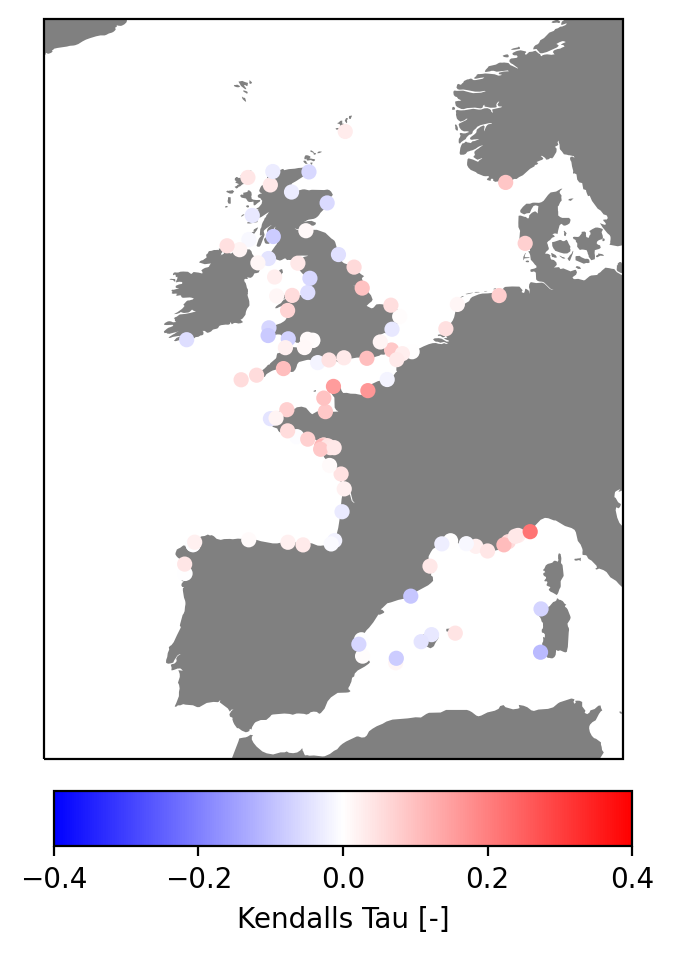

In [13]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%config InlineBackend.figure_format = 'retina'

fig=plt.figure()

ax = plt.subplot(111,projection=ccrs.Robinson(central_longitude=0))
ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='white')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

dKtau = ktau.sel(extreme_variate='surges',statistic='tau',window_center=2085).isel(member_id=0)-ktau.sel(extreme_variate='surges',statistic='tau',window_center=1920).isel(member_id=0)

sc=ax.scatter(ktau.lon,ktau.lat,c=dKtau,cmap='bwr',vmin=-.4,vmax=.4,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
      
cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Kendalls Tau [-]')
   
    
